# Serengeti Animal Detection: A Comparative Study of CNN and ViT Architectures

This notebook implements and compares three deep learning approaches for wildlife detection and classification on the Serengeti dataset:

1. **Basic CNN** - A custom convolutional neural network with classification and bounding box heads
2. **Transfer Learning CNN** - EfficientNetB0 backbone with custom heads  
3. **Vision Transformer (ViT)** - HuggingFace ViT backbone with custom heads (PyTorch)

## Table of Contents
1. [Setup & Imports](#setup)
2. [Utility Functions](#utilities)
3. [Data Acquisition](#data-acquisition)
4. [Data Exploration](#data-exploration)
5. [Data Preprocessing](#data-preprocessing)
6. [Model 1: Basic CNN](#basic-cnn)
7. [Model 2: Transfer Learning CNN (EfficientNetB0)](#transfer-cnn)
8. [Model 3: Vision Transformer (ViT)](#vit)
9. [Model Comparison](#comparison)
10. [Conclusions](#conclusions)

<a name="setup"></a>
## 1. Setup & Imports

Install required packages and import all necessary libraries for TensorFlow (CNN models) and PyTorch (ViT model).

In [1]:
# Install required packages
!pip install -q kagglehub transformers torch torchvision

In [2]:
# =============================================================================
# IMPORTS - All libraries needed for the project
# =============================================================================

# Standard libraries
import os
import subprocess
import json

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

# Scikit-learn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# TensorFlow/Keras (for CNN models)
import tensorflow as tf
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import (
    Input, Dense, Dropout, Flatten, Activation, Conv2D,
    MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
)
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import EfficientNetB0

# PyTorch (for ViT model)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel

# Image handling
from PIL import Image, ImageFile
from tqdm import tqdm
import kagglehub

# Allow loading truncated images (for corrupted file handling)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set visualization theme
sns.set_theme()

print("✓ All imports successful!")
print(f"✓ TensorFlow version: {tf.__version__}")
print(f"✓ PyTorch version: {torch.__version__}")

✓ All imports successful!
✓ TensorFlow version: 2.19.0
✓ PyTorch version: 2.9.0+cu126


In [ ]:
# =============================================================================
# CONFIGURATION CONSTANTS
# =============================================================================

# CNN Configuration (Basic CNN and Transfer Learning CNN)
CNN_IMAGE_SIZE = (128, 128)
CNN_BATCH_SIZE = 32

# ViT Configuration (Vision Transformer)
VIT_IMAGE_SIZE = (224, 224)
VIT_BATCH_SIZE = 16
VIT_EPOCHS = 50
VIT_LEARNING_RATE = 1e-4
VIT_PATIENCE = 5


# TensorFlow constants
AUTOTUNE = tf.data.AUTOTUNE

# Paths
LABELS_URL = "https://drive.google.com/uc?export=download&id=1F6PzJw6WqUUP_-a7r_xNpkKCjZ00tIWc"

# Random seed for reproducibility
SEED = 1337

print("Configuration:")
print(f"  CNN Image Size: {CNN_IMAGE_SIZE}, Batch Size: {CNN_BATCH_SIZE}")
print(f"  ViT Image Size: {VIT_IMAGE_SIZE}, Batch Size: {VIT_BATCH_SIZE}")
print(f"  Random Seed: {SEED}")

Configuration:
  CNN Image Size: (128, 128), Batch Size: 32
  ViT Image Size: (224, 224), Batch Size: 16
  Random Seed: 1337


Configuration:
  CNN Image Size: (128, 128), Batch Size: 32
  ViT Image Size: (224, 224), Batch Size: 16
  Random Seed: 1337


<a name="utilities"></a>
## 2. Utility Functions

Common functions used across all models for data loading, preprocessing, and visualization.

In [4]:
# =============================================================================
# DATA LOADING UTILITIES
# =============================================================================

def download_dataset(dataset_id: str = "silviamatoke/serengeti-dataset") -> str:
    """
    Download dataset from Kaggle using kagglehub.
    
    Returns:
        Path to the downloaded dataset
    """
    path = kagglehub.dataset_download(dataset_id)
    print("Path to dataset files:", path)
    return path


def load_labels(output_path: str = "labels.csv") -> pd.DataFrame:
    """
    Download labels CSV from Google Drive and load it.
    
    Returns:
        DataFrame with label data
    """
    subprocess.run(
        ["wget", "-q", LABELS_URL, "-O", output_path],
        check=True
    )
    print(f"✓ Downloaded labels.csv to {output_path}")
    labels_df = pd.read_csv(output_path)
    return labels_df


def prepare_label_data(
    labels_df: pd.DataFrame,
    path_base: str,
    min_animals: int = 1,
) -> tuple:
    """
    Prepare label data for training by filtering positives and encoding labels.
    
    Returns:
        Tuple of (filepaths, labels, bbox_array, label_encoder, positives_df)
    """
    # Filter images that contain animals
    positives = labels_df[labels_df["animal_count"] >= min_animals]
    
    # Build full file paths
    filepaths = path_base + positives["file_path"].values
    
    # Encode labels
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(positives["animal"].values).astype("int32")
    
    # Extract bounding box coordinates
    bbox_array = positives[["a1", "a2", "a3", "a4"]].values.astype("float32")
    
    return filepaths, labels, bbox_array, label_encoder, positives


def find_corrupted_images(filepaths):
    """
    Scan all image files and identify corrupted/truncated ones.
    
    Returns:
        Tuple of (valid_indices, corrupted_indices)
    """
    corrupted_indices = []
    valid_indices = []
    
    print("Scanning for corrupted images...")
    for idx, filepath in enumerate(tqdm(filepaths)):
        try:
            with Image.open(filepath) as img:
                img.verify()
            with Image.open(filepath) as img:
                img.load()
            valid_indices.append(idx)
        except Exception as e:
            corrupted_indices.append(idx)
            print(f"  ✗ Corrupted: {filepath}")
            print(f"    Error: {e}")
    
    return valid_indices, corrupted_indices


print("✓ Data loading utilities defined")

✓ Data loading utilities defined


In [5]:
# =============================================================================
# TENSORFLOW DATASET BUILDERS (for CNN models)
# =============================================================================

def _create_load_and_preprocess_fn(image_size):
    """Create a load_and_preprocess function with the specified image size."""
    
    def load_and_preprocess(path, label, bbox=None):
        image_bytes = tf.io.read_file(path)
        is_jpeg = tf.image.is_jpeg(image_bytes)

        def invalid():
            return (
                tf.zeros(image_size + (3,)),
                {"class_output": -1, "bbox_output": tf.zeros((4,))},
                path,
            )

        def valid():
            image = tf.image.decode_jpeg(image_bytes, channels=3)
            
            # Get original dimensions for bbox normalization
            orig_h = tf.cast(tf.shape(image)[0], tf.float32)
            orig_w = tf.cast(tf.shape(image)[1], tf.float32)
            
            # Resize to target size
            image = tf.image.resize(image, image_size)
            image = tf.image.convert_image_dtype(image, tf.float32)

            # Normalize bounding box relative to original image dimensions
            if bbox is not None:
                bbox_norm = bbox / [orig_w, orig_h, orig_w, orig_h]
            else:
                bbox_norm = tf.zeros((4,))

            bbox_norm = tf.cast(bbox_norm, tf.float32)
            return (image, {"class_output": label, "bbox_output": bbox_norm}, path)

        return tf.cond(is_jpeg, valid, invalid)
    
    return load_and_preprocess


def build_tf_dataset(filepaths, labels, bbox_array, image_size):
    """Build a TensorFlow dataset from file paths, labels, and bounding boxes."""
    load_and_preprocess = _create_load_and_preprocess_fn(image_size)
    
    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels, bbox_array))
    ds = ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE)
    ds = ds.filter(lambda image, labels, path: labels["class_output"] != -1)
    ds = ds.apply(tf.data.Dataset.ignore_errors)
    return ds


def split_dataset(ds, total_size, train_frac=0.8, val_frac=0.1, batch_size=32, shuffle_buffer=500, seed=SEED):
    """Split a dataset into train, validation, and test sets."""
    train_size = int(train_frac * total_size)
    val_size = int(val_frac * total_size)

    raw_ds = ds.shuffle(shuffle_buffer, seed=seed)

    train_raw = raw_ds.take(train_size)
    val_raw = raw_ds.skip(train_size).take(val_size)
    test_raw = raw_ds.skip(train_size + val_size)

    train_ds = train_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    val_ds = val_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)
    test_ds = test_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(batch_size).prefetch(AUTOTUNE)

    return {
        "train": train_ds, "val": val_ds, "test": test_ds,
        "train_raw": train_raw, "val_raw": val_raw, "test_raw": test_raw,
    }


print("✓ TensorFlow dataset builders defined")

✓ TensorFlow dataset builders defined


In [29]:
# =============================================================================
# VISUALIZATION UTILITIES
# =============================================================================

def denormalize_bbox(bbox, img_width, img_height):
    """Convert normalized bounding box coordinates to pixel coordinates."""
    x1 = int(bbox[0] * img_width)
    y1 = int(bbox[1] * img_height)
    x2 = int(bbox[2] * img_width)
    y2 = int(bbox[3] * img_height)
    return x1, y1, x2, y2


def compute_iou(box1, box2):
    """Compute IoU between two bounding boxes [x1, y1, x2, y2]."""
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    area1 = (box1[2] - box1[0]) * (box1[3] - box1[1])
    area2 = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union = area1 + area2 - intersection
    
    return intersection / union if union > 0 else 0


def visualize_sample(idx, filepaths, labels, bbox_array, label_encoder):
    """Visualize a single sample with its bounding box."""
    filepath = filepaths[idx]
    label = labels[idx]
    bbox = bbox_array[idx]
    class_name = label_encoder.inverse_transform([label])[0]
    
    try:
        img = Image.open(filepath)
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(img)
        
        x1, y1, x2, y2 = bbox
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        ax.set_title(f"Class: {class_name}\nBBox: [{x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}]")
        ax.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error loading image {filepath}: {e}")


def plot_tf_confusion_matrix(model, test_ds, label_encoder, title="Confusion Matrix"):
    """Plot confusion matrix for TensorFlow model."""
    y_true, y_pred = [], []
    
    for batch_images, batch_labels in test_ds:
        predictions = model.predict(batch_images, verbose=0)
        # Handle both dictionary and tuple outputs
        if isinstance(predictions, dict):
            class_logits = predictions["class_output"]
        else:
            class_logits = predictions[0]
        y_true.extend(batch_labels["class_output"].numpy())
        y_pred.extend(np.argmax(class_logits, axis=1))
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return y_true, y_pred


print("✓ Visualization utilities defined")

✓ Visualization utilities defined


---
## 3. Data Acquisition

Download the dataset from Kaggle and load the labels from Google Drive.

In [7]:
# Download dataset from Kaggle
download_dataset()

Using Colab cache for faster access to the 'serengeti-dataset' dataset.
Path to dataset files: /kaggle/input/serengeti-dataset
Path to dataset files: /kaggle/input/serengeti-dataset


'/kaggle/input/serengeti-dataset'

In [8]:
# Load labels from Google Drive (using vit.ipynb approach)
labels_df = load_labels()

print(f"Labels DataFrame shape: {labels_df.shape}")
labels_df.head()

✓ Downloaded labels.csv to labels.csv
Labels DataFrame shape: (1277, 37)


,file_path,animal,sequence,image_path,animal_count,a1,a2,a3,a4,b1,...,f3,f4,g1,g2,g3,g4,h1,h2,h3,h4
0,1.02-Agouti/SEQ75520/SEQ75520_IMG_0001.JPG,Agouti,SEQ75520,SEQ75520_IMG0001.JPG,1,1121.0,841.0,1392.0,1051.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.02-Agouti/SEQ75520/SEQ75520_IMG_0002.JPG,Agouti,SEQ75520,SEQ75520_IMG0002.JPG,1,1227.0,825.0,1537.0,1054.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.02-Agouti/SEQ75520/SEQ75520_IMG_0003.JPG,Agouti,SEQ75520,SEQ75520_IMG0003.JPG,1,1401.0,788.0,1734.0,1027.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.02-Agouti/SEQ75520/SEQ75520_IMG_0004.JPG,Agouti,SEQ75520,SEQ75520_IMG0004.JPG,1,1619.0,757.0,1916.0,984.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.02-Agouti/SEQ75520/SEQ75520_IMG_0005.JPG,Agouti,SEQ75520,SEQ75520_IMG0005.JPG,1,1780.0,714.0,1918.0,918.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


---
## 4. Exploratory Data Analysis

Analyze the dataset to understand its structure and characteristics.

In [9]:
# Check for missing values
print("Missing values per column:")
print(labels_df.isnull().sum())
print(f"\nTotal missing values: {labels_df.isnull().sum().sum()}")

Missing values per column:
file_path          0
animal             0
sequence           0
image_path         0
animal_count       0
a1               330
a2               330
a3               330
a4               330
b1              1189
b2              1189
b3              1189
b4              1189
c1              1246
c2              1246
c3              1246
c4              1246
d1              1258
d2              1258
d3              1258
d4              1258
e1              1261
e2              1261
e3              1261
e4              1261
f1              1271
f2              1271
f3              1271
f4              1271
g1              1276
g2              1276
g3              1276
g4              1276
h1              1276
h2              1276
h3              1276
h4              1276
dtype: int64

Total missing values: 36428


Number of unique animal classes: 19

Class distribution:
animal
Red_Deer             166
Agouti               110
Collared_Peccary      90
Wild_Boar             75
White_Tailed_Deer     70
Coiban_Agouti         70
Great_Tinamou         70
Paca                  69
Roe_Deer              66
Ocelot                66
Red_Squirrel          60
Bird_spec             55
White-nosed_Coati     50
Spiny_Rat             50
Common_Opossum        50
Wood_Mouse            50
Mouflon               45
European_Hare         35
Red_Fox               30
Name: count, dtype: int64


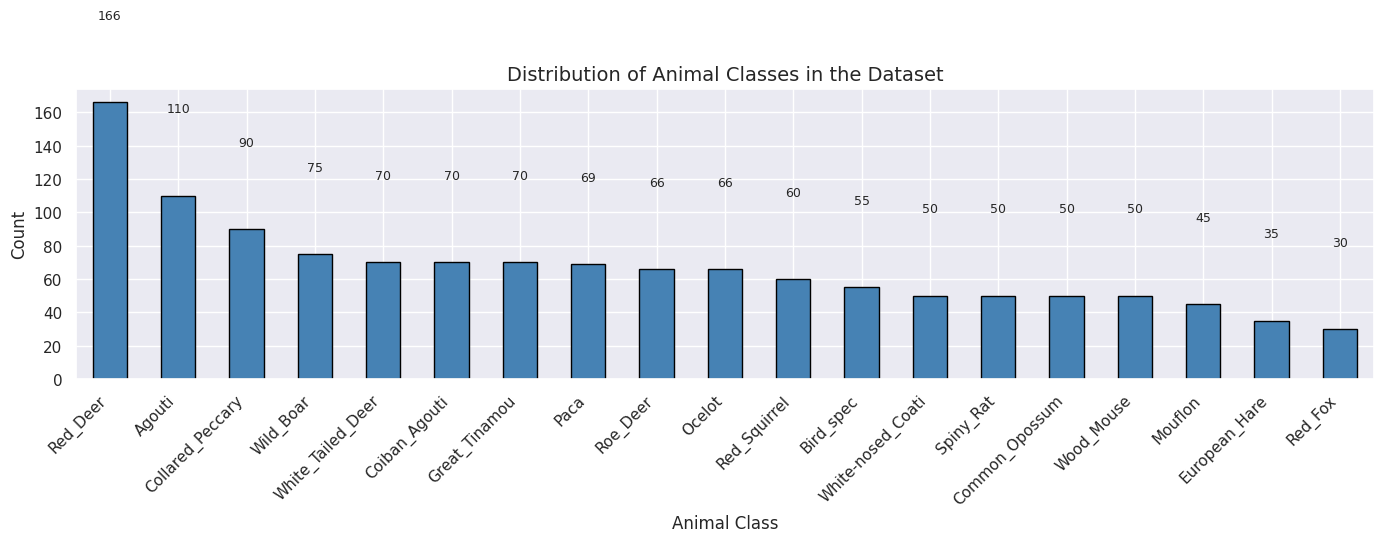

In [10]:
# Animal class distribution
animal_counts = labels_df['animal'].value_counts()
print(f"Number of unique animal classes: {len(animal_counts)}")
print(f"\nClass distribution:")
print(animal_counts)

# Visualize class distribution
plt.figure(figsize=(14, 6))
ax = animal_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribution of Animal Classes in the Dataset', fontsize=14)
plt.xlabel('Animal Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')

# Add value labels on bars
for i, v in enumerate(animal_counts):
    ax.text(i, v + 50, str(v), ha='center', fontsize=9)

plt.tight_layout()
plt.show()

/tmp/ipython-input-2217622964.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled = df_with_animals.groupby('animal', group_keys=False).apply(


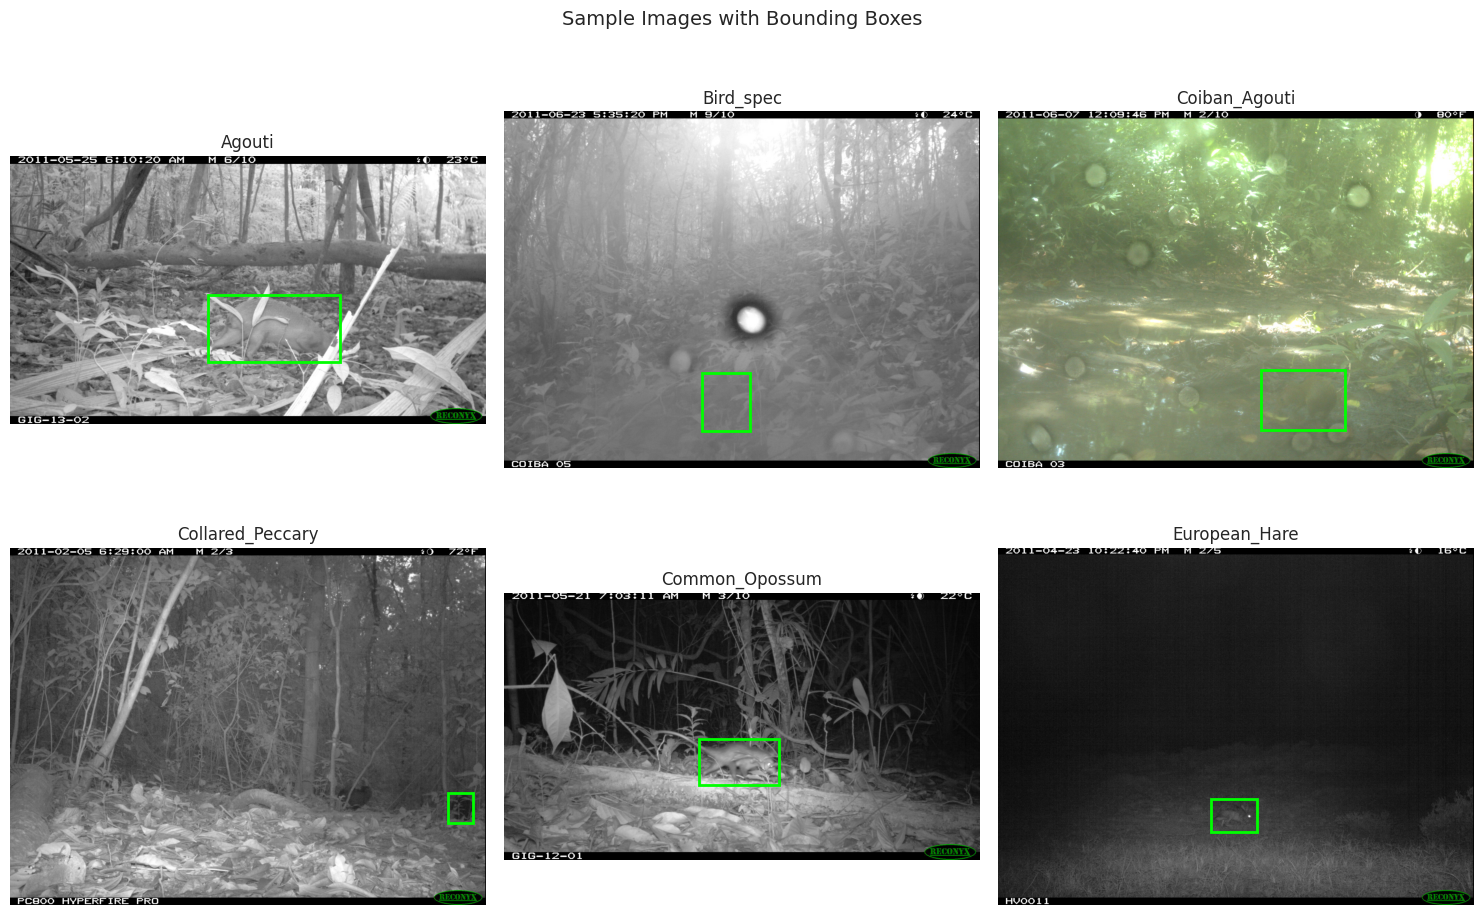

In [12]:
# Display sample images with bounding boxes
# First, set the path base for images
PATH_BASE = "/kaggle/input/serengeti-dataset/Set1/"

def display_sample_images(df, path_base, n_samples=6):
    """Display sample images with bounding boxes from each class."""
    # Filter to only rows with animals
    df_with_animals = df[df["animal_count"] > 0].copy()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    # Get samples from different classes
    sampled = df_with_animals.groupby('animal', group_keys=False).apply(
        lambda x: x.sample(1, random_state=42)
    ).reset_index(drop=True)
    sampled = sampled.head(n_samples)
    
    for idx, (ax, (_, row)) in enumerate(zip(axes, sampled.iterrows())):
        try:
            full_path = path_base + row['file_path']
            img = Image.open(full_path)
            ax.imshow(img)
            
            # Draw bounding box (using a1, a2, a3, a4 columns)
            x1, y1, x2, y2 = row['a1'], row['a2'], row['a3'], row['a4']
            if not np.isnan(x1):  # Only draw if bbox exists
                rect = patches.Rectangle(
                    (x1, y1), x2 - x1, y2 - y1,
                    linewidth=2, edgecolor='lime', facecolor='none'
                )
                ax.add_patch(rect)
            ax.set_title(f"{row['animal']}", fontsize=12)
            ax.axis('off')
        except Exception as e:
            ax.set_title(f"Error: {e}")
            ax.axis('off')
    
    plt.suptitle('Sample Images with Bounding Boxes', fontsize=14)
    plt.tight_layout()
    plt.show()

display_sample_images(labels_df, PATH_BASE)

---
## 5. Data Preprocessing

Prepare the data for model training including label encoding, bounding box preparation, and train/test splitting.

In [13]:
# Prepare label data first (to get filepaths for corruption check)
# Filter for images with animals and build full paths
positives = labels_df[labels_df["animal_count"] > 0].copy()
filepaths = np.array([PATH_BASE + fp for fp in positives["file_path"].values])

# Scan for corrupted images
valid_indices, corrupted_indices = find_corrupted_images(filepaths)

print(f"\nTotal images: {len(filepaths)}")
print(f"Valid images: {len(valid_indices)}")
print(f"Corrupted images: {len(corrupted_indices)}")

if len(corrupted_indices) > 0:
    print(f"Removing {len(corrupted_indices)} corrupted images...")
    positives = positives.iloc[valid_indices].reset_index(drop=True)
    filepaths = filepaths[valid_indices]
    print(f"Dataset size after cleaning: {len(filepaths)}")

Scanning for corrupted images...


100%|██████████| 947/947 [00:22<00:00, 42.56it/s]


Total images: 947
Valid images: 947
Corrupted images: 0


In [14]:
# Encode labels and prepare bbox array
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(positives["animal"].values).astype("int32")

# Extract bounding box coordinates (using a1, a2, a3, a4)
bbox_array = positives[["a1", "a2", "a3", "a4"]].values.astype("float32")

NUM_CLASSES = len(label_encoder.classes_)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {label_encoder.classes_}")
print(f"Total samples: {len(filepaths)}")
print(f"Labels shape: {labels.shape}")
print(f"BBox array shape: {bbox_array.shape}")

Number of classes: 19
Classes: ['Agouti' 'Bird_spec' 'Coiban_Agouti' 'Collared_Peccary' 'Common_Opossum'
 'European_Hare' 'Great_Tinamou' 'Mouflon' 'Ocelot' 'Paca' 'Red_Deer'
 'Red_Fox' 'Red_Squirrel' 'Roe_Deer' 'Spiny_Rat' 'White-nosed_Coati'
 'White_Tailed_Deer' 'Wild_Boar' 'Wood_Mouse']
Total samples: 947
Labels shape: (947,)
BBox array shape: (947, 4)


In [15]:
# Split data into train/test sets (stratified by class)
TEST_SPLIT = 0.2
RANDOM_SEED = SEED

train_filepaths, test_filepaths, train_labels, test_labels, train_bboxes, test_bboxes = train_test_split(
    filepaths, labels, bbox_array,
    test_size=TEST_SPLIT,
    random_state=RANDOM_SEED,
    stratify=labels
)

print(f"Training samples: {len(train_filepaths)}")
print(f"Testing samples: {len(test_filepaths)}")

Training samples: 757
Testing samples: 190


---
## 6. Model 1: Basic CNN

A custom convolutional neural network with multi-output heads for classification and bounding box regression.

In [16]:
# Build TensorFlow datasets for CNN models (128x128)
print("Building TensorFlow datasets for CNN models...")

# Create validation split from training data (12.5% of train = ~10% of total)
cnn_train_files, cnn_val_files, cnn_train_labels, cnn_val_labels, cnn_train_bboxes, cnn_val_bboxes = train_test_split(
    train_filepaths, train_labels, train_bboxes, 
    test_size=0.125, random_state=RANDOM_SEED, stratify=train_labels
)

# Build raw datasets
cnn_train_ds_raw = build_tf_dataset(cnn_train_files, cnn_train_labels, cnn_train_bboxes, image_size=CNN_IMAGE_SIZE)
cnn_val_ds_raw = build_tf_dataset(cnn_val_files, cnn_val_labels, cnn_val_bboxes, image_size=CNN_IMAGE_SIZE)
cnn_test_ds_raw = build_tf_dataset(test_filepaths, test_labels, test_bboxes, image_size=CNN_IMAGE_SIZE)

# Batch and prefetch
cnn_train_ds = cnn_train_ds_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).shuffle(500).batch(CNN_BATCH_SIZE).prefetch(AUTOTUNE)
cnn_val_ds = cnn_val_ds_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(CNN_BATCH_SIZE).prefetch(AUTOTUNE)
cnn_test_ds = cnn_test_ds_raw.map(lambda x, y, p: (x, y), num_parallel_calls=AUTOTUNE).batch(CNN_BATCH_SIZE).prefetch(AUTOTUNE)

print(f"✓ CNN Training samples: {len(cnn_train_files)}")
print(f"✓ CNN Validation samples: {len(cnn_val_files)}")
print(f"✓ CNN Test samples: {len(test_filepaths)}")

Building TensorFlow datasets for CNN models...
✓ CNN Training samples: 662
✓ CNN Validation samples: 95
✓ CNN Test samples: 190
✓ CNN Training samples: 662
✓ CNN Validation samples: 95
✓ CNN Test samples: 190


In [17]:
# =============================================================================
# BASIC CNN MODEL ARCHITECTURE
# =============================================================================

input_shape = CNN_IMAGE_SIZE + (3,)

# Multi-output CNN with classification and bounding box regression heads
inputs = Input(shape=input_shape, name="image_input")

# Convolutional backbone
x = Conv2D(32, (3, 3), activation='relu')(inputs)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)

# Classification head
basic_cnn_class_output = Dense(NUM_CLASSES, activation='softmax', name="class_output")(x)

# Bounding box regression head
basic_cnn_bbox_output = Dense(4, activation='linear', name="bbox_output")(x)

# Build the model
basic_cnn_model = Model(inputs=inputs, outputs=[basic_cnn_class_output, basic_cnn_bbox_output])

# Compile with multi-output losses
basic_cnn_model.compile(
    optimizer='adam',
    loss={
        "class_output": "sparse_categorical_crossentropy",
        "bbox_output": "mse"
    },
    loss_weights={
        "class_output": 1.0,
        "bbox_output": 1.0
    },
    metrics={
        "class_output": "accuracy",
        "bbox_output": "mse"
    }
)

basic_cnn_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 126, 126,  │        896 │ image_input[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 63, 63,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 63, 63,    │        128 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 61, 61,    │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 30, 30,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        128 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 26, 26,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 43264)     │          0 │ conv2d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │ 22,151,680 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 19)        │      9,747 │ dense[0][0]       │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      2,052 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,229,559 (84.80 MB)

 Trainable params: 22,229,303 (84.80 MB)

 Non-trainable params: 256 (1.00 KB)

In [19]:
# Train Basic CNN
CNN_EPOCHS = 100

basic_cnn_history = basic_cnn_model.fit(
    cnn_train_ds, 
    epochs=CNN_EPOCHS, 
    validation_data=cnn_val_ds
)

Epoch 1/100
     18/Unknown 1s 24ms/step - bbox_output_loss: 1.8622 - bbox_output_mse: 1.8622 - class_output_accuracy: 0.0866 - class_output_loss: 4.7180 - loss: 6.5802

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 206ms/step - bbox_output_loss: 1.7145 - bbox_output_mse: 1.7153 - class_output_accuracy: 0.0905 - class_output_loss: 4.5793 - loss: 6.2960 - val_bbox_output_loss: 1.0864 - val_bbox_output_mse: 1.0882 - val_class_output_accuracy: 0.0737 - val_class_output_loss: 3.3532 - val_loss: 4.4401
Epoch 2/100
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bbox_output_loss: 0.3019 - bbox_output_mse: 0.3019 - class_output_accuracy: 0.1770 - class_output_loss: 2.6522 - loss: 2.9541 - val_bbox_output_loss: 0.3419 - val_bbox_output_mse: 0.3423 - val_class_output_accuracy: 0.0947 - val_class_output_loss: 2.7629 - val_loss: 3.1048
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - bbox_output_loss: 0.3019 - bbox_output_mse: 0.3019 - class_output_accuracy: 0.1770 - class_output_loss: 2.6522 - loss: 2.9541 - val_bbox_output_loss: 0.3419 - val_bbox_output_mse: 0.3423 - val_class_output_accuracy: 0.0947 - val_class_output_loss: 2.7629 - val_loss: 3.1048
Epoch 3/100
21/

In [20]:
# Evaluate Basic CNN on test set
print("Evaluating Basic CNN on test set...")
basic_cnn_test_results = basic_cnn_model.evaluate(cnn_test_ds, verbose=1)

# Store metrics
basic_cnn_metrics = dict(zip(basic_cnn_model.metrics_names, basic_cnn_test_results))
print("\nBasic CNN Test Results:")
for name, value in basic_cnn_metrics.items():
    print(f"  {name}: {value:.4f}")

Evaluating Basic CNN on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 603ms/step - bbox_output_loss: 0.0373 - bbox_output_mse: 0.0373 - class_output_accuracy: 0.9965 - class_output_loss: 0.0265 - loss: 0.0639

Basic CNN Test Results:
  loss: 0.0632
  compile_metrics: 0.0298
  class_output_loss: 0.0328
  bbox_output_loss: 0.0329
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 603ms/step - bbox_output_loss: 0.0373 - bbox_output_mse: 0.0373 - class_output_accuracy: 0.9965 - class_output_loss: 0.0265 - loss: 0.0639

Basic CNN Test Results:
  loss: 0.0632
  compile_metrics: 0.0298
  class_output_loss: 0.0328
  bbox_output_loss: 0.0329


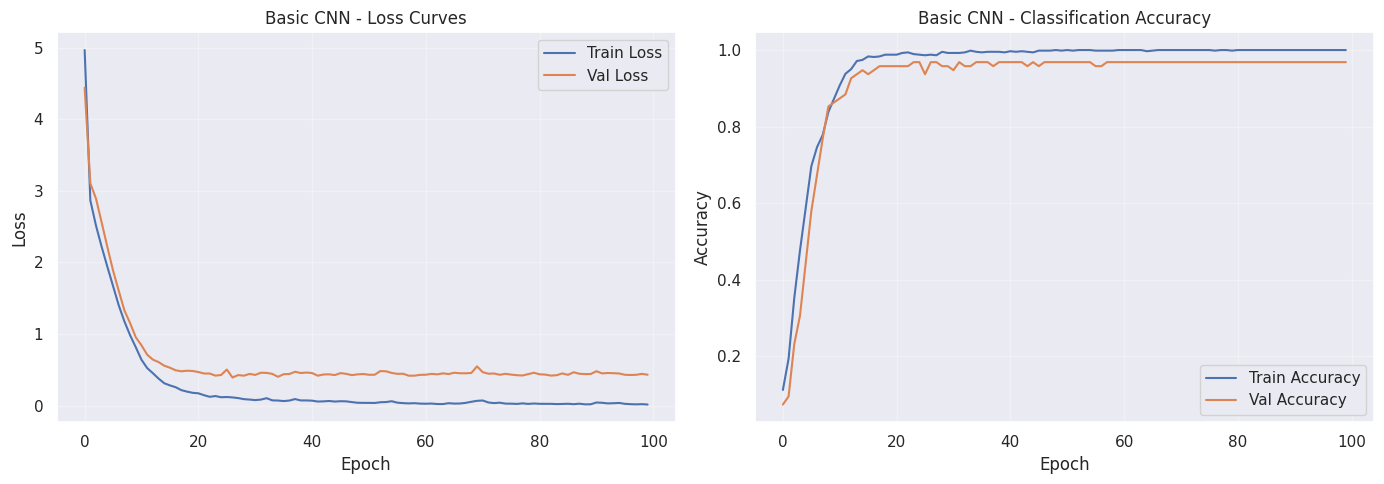

In [21]:
# Plot Basic CNN learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(basic_cnn_history.history['loss'], label='Train Loss')
axes[0].plot(basic_cnn_history.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Basic CNN - Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(basic_cnn_history.history['class_output_accuracy'], label='Train Accuracy')
axes[1].plot(basic_cnn_history.history['val_class_output_accuracy'], label='Val Accuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Basic CNN - Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

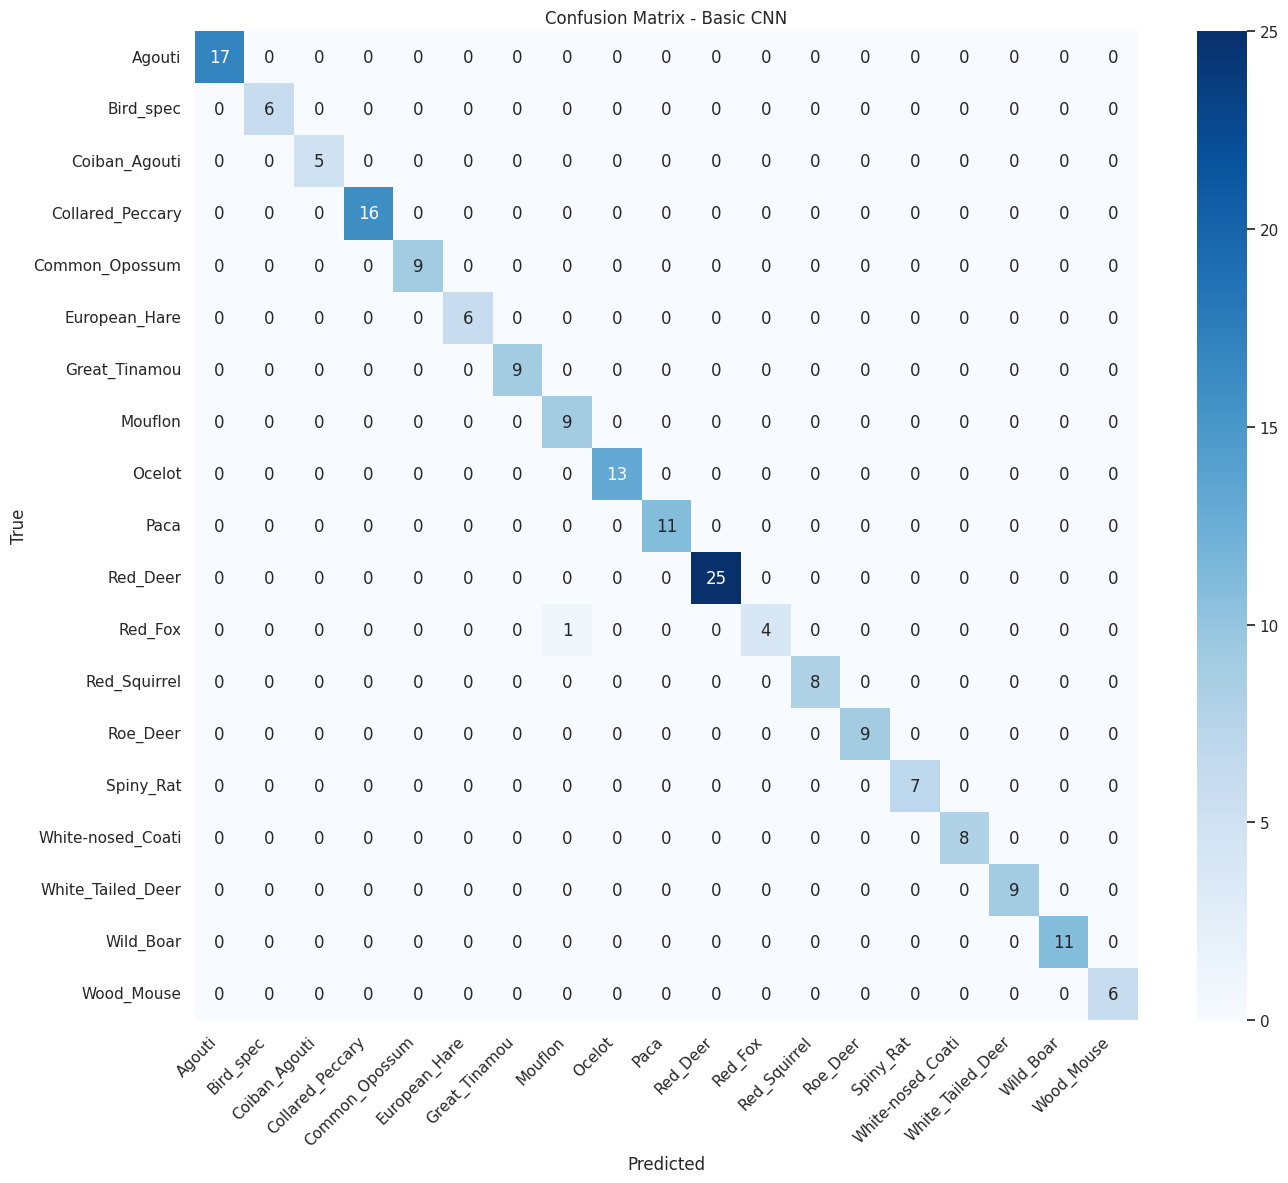


Basic CNN Classification Report:
                   precision    recall  f1-score   support

           Agouti       1.00      1.00      1.00        17
        Bird_spec       1.00      1.00      1.00         6
    Coiban_Agouti       1.00      1.00      1.00         5
 Collared_Peccary       1.00      1.00      1.00        16
   Common_Opossum       1.00      1.00      1.00         9
    European_Hare       1.00      1.00      1.00         6
    Great_Tinamou       1.00      1.00      1.00         9
          Mouflon       0.90      1.00      0.95         9
           Ocelot       1.00      1.00      1.00        13
             Paca       1.00      1.00      1.00        11
         Red_Deer       1.00      1.00      1.00        25
          Red_Fox       1.00      0.80      0.89         5
     Red_Squirrel       1.00      1.00      1.00         8
         Roe_Deer       1.00      1.00      1.00         9
        Spiny_Rat       1.00      1.00      1.00         7
White-nosed_Coati    

In [22]:
# Basic CNN Confusion Matrix
basic_cnn_y_true, basic_cnn_y_pred = plot_tf_confusion_matrix(
    basic_cnn_model, cnn_test_ds, label_encoder, 
    title="Confusion Matrix - Basic CNN"
)

# Classification report
print("\nBasic CNN Classification Report:")
print("=" * 60)
print(classification_report(basic_cnn_y_true, basic_cnn_y_pred, target_names=label_encoder.classes_, zero_division=0))

---
## 7. Model 2: Transfer Learning CNN (EfficientNetB0)

A transfer learning approach using EfficientNetB0 as the backbone with custom heads for classification and bounding box regression. Training proceeds in two phases:
1. **Phase 1**: Freeze backbone, train custom heads only
2. **Phase 2**: Unfreeze top layers of backbone for fine-tuning

In [23]:
# =============================================================================
# TRANSFER LEARNING CNN MODEL (EfficientNetB0)
# =============================================================================

from keras.applications import EfficientNetB0
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Create the EfficientNetB0 backbone with pretrained ImageNet weights
efficientnet_base = EfficientNetB0(
    include_top=False,
    input_shape=CNN_IMAGE_SIZE + (3,),
    weights="imagenet"
)

# Freeze the base model for Phase 1 training
efficientnet_base.trainable = False

# Build the model with two output heads
transfer_inputs = tf.keras.Input(shape=CNN_IMAGE_SIZE + (3,))

# Pass through pretrained backbone
x = efficientnet_base(transfer_inputs, training=False)

# Global pooling and dropout
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)

# Classification head
transfer_class_output = Dense(NUM_CLASSES, activation="softmax", name="class_output")(x)

# Bounding box regression head
transfer_bbox_output = Dense(4, name="bbox_output")(x)

# Build the multi-output model
transfer_cnn_model = Model(
    inputs=transfer_inputs,
    outputs={
        "class_output": transfer_class_output,
        "bbox_output": transfer_bbox_output
    },
    name="transfer_learning_cnn"
)

# Compile for Phase 1
transfer_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss={
        "class_output": tf.keras.losses.SparseCategoricalCrossentropy(),
        "bbox_output": tf.keras.losses.MeanSquaredError()
    },
    loss_weights={"class_output": 1.0, "bbox_output": 1.0},
    metrics={
        "class_output": ["accuracy"],
        "bbox_output": [tf.keras.metrics.MeanAbsoluteError(name="mae")]
    }
)

transfer_cnn_model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "transfer_learning_cnn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 4, 4,      │  4,049,571 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetb0[0… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      5,124 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 19)        │     24,339 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,079,034 (15.56 MB)

 Trainable params: 29,463 (115.09 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [24]:
# =============================================================================
# PHASE 1: Feature Extraction (Frozen Backbone)
# =============================================================================

print("Phase 1: Training with frozen EfficientNetB0 backbone...")
print("=" * 60)

TRANSFER_EPOCHS_PHASE1 = 10

# Callbacks
phase1_checkpoint = ModelCheckpoint(
    "transfer_cnn_best_phase1.keras",
    monitor="val_class_output_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

phase1_earlystop = EarlyStopping(
    monitor="val_class_output_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

# Train Phase 1
transfer_history_phase1 = transfer_cnn_model.fit(
    cnn_train_ds,
    validation_data=cnn_val_ds,
    epochs=TRANSFER_EPOCHS_PHASE1,
    callbacks=[phase1_checkpoint, phase1_earlystop]
)

print("\n✓ Phase 1 training complete!")

Phase 1: Training with frozen EfficientNetB0 backbone...
Epoch 1/10
     21/Unknown 44s 814ms/step - bbox_output_loss: 0.4371 - bbox_output_mae: 0.5281 - class_output_accuracy: 0.1391 - class_output_loss: 2.8725 - loss: 3.3101

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_class_output_accuracy improved from -inf to 0.57895, saving model to transfer_cnn_best_phase1.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - bbox_output_loss: 0.4335 - bbox_output_mae: 0.5257 - class_output_accuracy: 0.1450 - class_output_loss: 2.8586 - loss: 3.2930 - val_bbox_output_loss: 0.1214 - val_bbox_output_mae: 0.2671 - val_class_output_accuracy: 0.5789 - val_class_output_loss: 1.9449 - val_loss: 2.0672
21/21 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - bbox_output_loss: 0.4335 - bbox_output_mae: 0.5257 - class_output_accuracy: 0.1450 - class_output_loss: 2.8586 - loss: 3.2930 - val_bbox_output_loss: 0.1214 - val_bbox_output_mae: 0.2671 - val_class_output_accuracy: 0.5789 - val_class_output_loss: 1.9449 - val_loss: 2.0672
Epoch 2/10
Epoch 2/10
18/21 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - bbox_output_loss: 0.2562 - bbox_output_mae: 0.4010 - class_output_accuracy: 0.5515 - class_output_loss: 1.7587 - loss: 2.0149
Epoch 2: val_class_output_accuracy improved from 0.57895 to 0.7052

In [25]:
# =============================================================================
# PHASE 2: Fine-tuning (Unfreeze Top Layers)
# =============================================================================

print("Phase 2: Fine-tuning with unfrozen top layers...")
print("=" * 60)

# Unfreeze the EfficientNet backbone
efficientnet_base.trainable = True

# Only fine-tune the top ~40 layers
fine_tune_at = max(0, len(efficientnet_base.layers) - 40)
for i, layer in enumerate(efficientnet_base.layers):
    layer.trainable = (i >= fine_tune_at)

print(f"Fine-tuning from layer {fine_tune_at} to {len(efficientnet_base.layers) - 1}")

# Re-compile with smaller learning rate
transfer_cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss={
        "class_output": tf.keras.losses.SparseCategoricalCrossentropy(),
        "bbox_output": tf.keras.losses.MeanSquaredError()
    },
    loss_weights={"class_output": 1.0, "bbox_output": 1.0},
    metrics={
        "class_output": ["accuracy"],
        "bbox_output": [tf.keras.metrics.MeanAbsoluteError(name="mae")]
    }
)

TRANSFER_EPOCHS_PHASE2 = 10

# Callbacks for Phase 2
phase2_checkpoint = ModelCheckpoint(
    "transfer_cnn_best_phase2.keras",
    monitor="val_class_output_accuracy",
    save_best_only=True,
    mode="max",
    verbose=1
)

phase2_earlystop = EarlyStopping(
    monitor="val_class_output_accuracy",
    patience=5,
    restore_best_weights=True,
    mode="max",
    verbose=1
)

# Train Phase 2
transfer_history_phase2 = transfer_cnn_model.fit(
    cnn_train_ds,
    validation_data=cnn_val_ds,
    epochs=TRANSFER_EPOCHS_PHASE2,
    callbacks=[phase2_checkpoint, phase2_earlystop]
)

print("\n✓ Phase 2 fine-tuning complete!")

Phase 2: Fine-tuning with unfrozen top layers...
Fine-tuning from layer 198 to 237
Epoch 1/10
     21/Unknown 45s 757ms/step - bbox_output_loss: 0.5815 - bbox_output_mae: 0.6397 - class_output_accuracy: 0.8161 - class_output_loss: 0.8821 - loss: 1.4637
Epoch 1: val_class_output_accuracy improved from -inf to 0.93684, saving model to transfer_cnn_best_phase2.keras

Epoch 1: val_class_output_accuracy improved from -inf to 0.93684, saving model to transfer_cnn_best_phase2.keras
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - bbox_output_loss: 0.5799 - bbox_output_mae: 0.6388 - class_output_accuracy: 0.8167 - class_output_loss: 0.8812 - loss: 1.4613 - val_bbox_output_loss: 0.0513 - val_bbox_output_mae: 0.1702 - val_class_output_accuracy: 0.9368 - val_class_output_loss: 0.3206 - val_loss: 0.3727
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - bbox_output_loss: 0.5799 - bbox_output_mae: 0.6388 - class_output_accuracy: 0.8167 - class_output_loss: 0.8812 - loss: 1.4613 - val_bbox_output_loss: 0.0

In [26]:
# Evaluate Transfer Learning CNN on test set
print("Evaluating Transfer Learning CNN on test set...")
transfer_test_results = transfer_cnn_model.evaluate(cnn_test_ds, verbose=1)

# Store metrics
transfer_cnn_metrics = dict(zip(transfer_cnn_model.metrics_names, transfer_test_results))
print("\nTransfer Learning CNN Test Results:")
for name, value in transfer_cnn_metrics.items():
    print(f"  {name}: {value:.4f}")

Evaluating Transfer Learning CNN on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - bbox_output_loss: 0.0624 - bbox_output_mae: 0.1912 - class_output_accuracy: 0.9651 - class_output_loss: 0.2839 - loss: 0.3469

Transfer Learning CNN Test Results:
  loss: 0.3247
  compile_metrics: 0.2648
  class_output_loss: 0.0579
  bbox_output_loss: 0.1863
6/6 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - bbox_output_loss: 0.0624 - bbox_output_mae: 0.1912 - class_output_accuracy: 0.9651 - class_output_loss: 0.2839 - loss: 0.3469

Transfer Learning CNN Test Results:
  loss: 0.3247
  compile_metrics: 0.2648
  class_output_loss: 0.0579
  bbox_output_loss: 0.1863


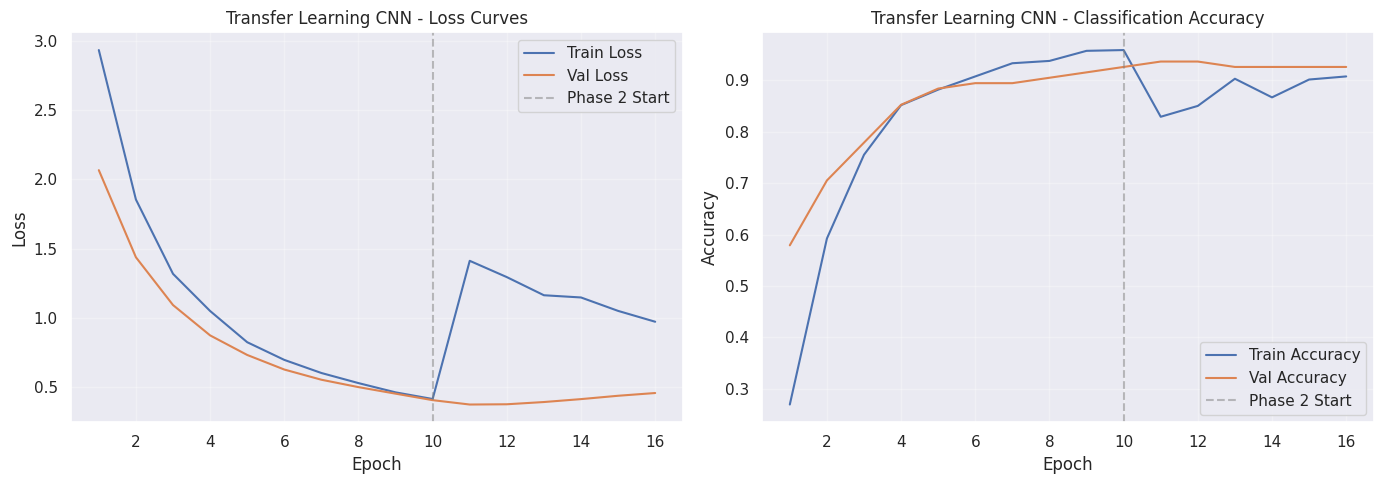

In [27]:
# Plot Transfer Learning CNN learning curves (combined Phase 1 + Phase 2)
def concat_history(h1, h2, key):
    """Concatenate history from two phases."""
    return h1.history.get(key, []) + h2.history.get(key, [])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Combine histories
transfer_train_acc = concat_history(transfer_history_phase1, transfer_history_phase2, 'class_output_accuracy')
transfer_val_acc = concat_history(transfer_history_phase1, transfer_history_phase2, 'val_class_output_accuracy')
transfer_train_loss = concat_history(transfer_history_phase1, transfer_history_phase2, 'loss')
transfer_val_loss = concat_history(transfer_history_phase1, transfer_history_phase2, 'val_loss')

epochs_total = range(1, len(transfer_train_acc) + 1)

# Loss curves
axes[0].plot(epochs_total, transfer_train_loss, label='Train Loss')
axes[0].plot(epochs_total, transfer_val_loss, label='Val Loss')
axes[0].axvline(x=len(transfer_history_phase1.history['loss']), color='gray', linestyle='--', alpha=0.5, label='Phase 2 Start')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Transfer Learning CNN - Loss Curves')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(epochs_total, transfer_train_acc, label='Train Accuracy')
axes[1].plot(epochs_total, transfer_val_acc, label='Val Accuracy')
axes[1].axvline(x=len(transfer_history_phase1.history['loss']), color='gray', linestyle='--', alpha=0.5, label='Phase 2 Start')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Transfer Learning CNN - Classification Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

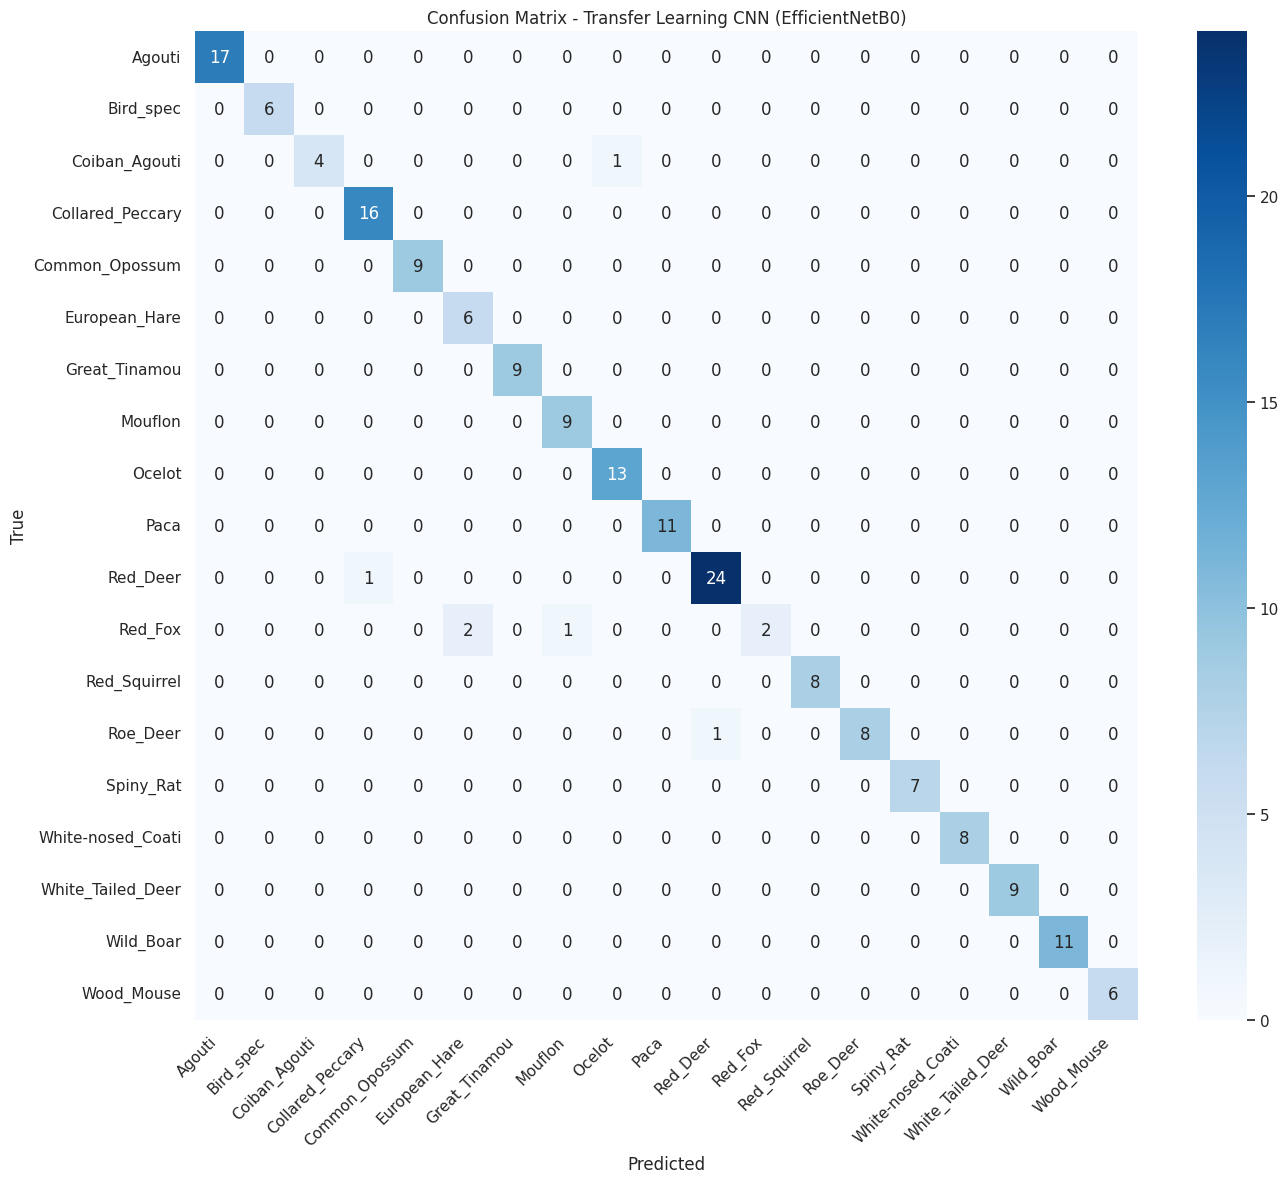


Transfer Learning CNN Classification Report:
                   precision    recall  f1-score   support

           Agouti       1.00      1.00      1.00        17
        Bird_spec       1.00      1.00      1.00         6
    Coiban_Agouti       1.00      0.80      0.89         5
 Collared_Peccary       0.94      1.00      0.97        16
   Common_Opossum       1.00      1.00      1.00         9
    European_Hare       0.75      1.00      0.86         6
    Great_Tinamou       1.00      1.00      1.00         9
          Mouflon       0.90      1.00      0.95         9
           Ocelot       0.93      1.00      0.96        13
             Paca       1.00      1.00      1.00        11
         Red_Deer       0.96      0.96      0.96        25
          Red_Fox       1.00      0.40      0.57         5
     Red_Squirrel       1.00      1.00      1.00         8
         Roe_Deer       1.00      0.89      0.94         9
        Spiny_Rat       1.00      1.00      1.00         7
White-nos

In [30]:
# Transfer Learning CNN Confusion Matrix
transfer_y_true, transfer_y_pred = plot_tf_confusion_matrix(
    transfer_cnn_model, cnn_test_ds, label_encoder,
    title="Confusion Matrix - Transfer Learning CNN (EfficientNetB0)"
)

# Classification report
print("\nTransfer Learning CNN Classification Report:")
print("=" * 60)
print(classification_report(transfer_y_true, transfer_y_pred, target_names=label_encoder.classes_, zero_division=0))

---
## 8. Model 3: Vision Transformer (ViT)

A Vision Transformer using HuggingFace's pretrained ViT-Base-Patch16-224 as the backbone with custom PyTorch heads for classification and bounding box regression.

In [31]:
# =============================================================================
# PYTORCH SETUP FOR ViT
# =============================================================================

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import ViTModel
from tqdm import tqdm

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ Device: {device}")
if torch.cuda.is_available():
    print(f"✓ GPU: {torch.cuda.get_device_name(0)}")

✓ PyTorch version: 2.9.0+cu126
✓ Device: cuda
✓ GPU: NVIDIA L4


In [32]:
# =============================================================================
# PYTORCH DATASET CLASS
# =============================================================================

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class SerengetiDataset(Dataset):
    """PyTorch Dataset for Serengeti wildlife images with bounding boxes."""
    
    def __init__(self, filepaths, labels, bboxes, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.bboxes = bboxes  # Raw pixel coordinates
        self.transform = transform
    
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        # Load image and get ORIGINAL dimensions before any transform
        try:
            img = Image.open(self.filepaths[idx]).convert('RGB')
            orig_w, orig_h = img.size  # Original dimensions for bbox normalization
        except Exception as e:
            print(f"Warning: Failed to load {self.filepaths[idx]}: {e}")
            img = Image.new('RGB', VIT_IMAGE_SIZE, (0, 0, 0))
            orig_w, orig_h = VIT_IMAGE_SIZE
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        # NORMALIZE BBOX using ORIGINAL image dimensions (not resized)
        raw_bbox = self.bboxes[idx].astype(np.float32)
        bbox_norm = raw_bbox / np.array([orig_w, orig_h, orig_w, orig_h], dtype=np.float32)
        bbox_norm = np.clip(bbox_norm, 0.0, 1.0)
        bbox = torch.tensor(bbox_norm, dtype=torch.float32)
        
        return img, label, bbox


# Data transforms for ViT
vit_train_transform = transforms.Compose([
    transforms.Resize(VIT_IMAGE_SIZE),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

vit_val_transform = transforms.Compose([
    transforms.Resize(VIT_IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("✓ SerengetiDataset class and transforms defined")

✓ SerengetiDataset class and transforms defined


In [33]:
# Create PyTorch DataLoaders for ViT
# Split training data into train/val for ViT (70% train, 15% val, 15% test)
vit_train_files, vit_temp_files, vit_train_labels, vit_temp_labels, vit_train_bboxes, vit_temp_bboxes = train_test_split(
    filepaths, labels, bbox_array, test_size=0.3, random_state=RANDOM_SEED, stratify=labels
)

vit_val_files, vit_test_files, vit_val_labels, vit_test_labels, vit_val_bboxes, vit_test_bboxes = train_test_split(
    vit_temp_files, vit_temp_labels, vit_temp_bboxes, test_size=0.5, random_state=RANDOM_SEED, stratify=vit_temp_labels
)

# Create Datasets
vit_train_dataset = SerengetiDataset(vit_train_files, vit_train_labels, vit_train_bboxes, transform=vit_train_transform)
vit_val_dataset = SerengetiDataset(vit_val_files, vit_val_labels, vit_val_bboxes, transform=vit_val_transform)
vit_test_dataset = SerengetiDataset(vit_test_files, vit_test_labels, vit_test_bboxes, transform=vit_val_transform)

# Create DataLoaders
vit_train_loader = DataLoader(vit_train_dataset, batch_size=VIT_BATCH_SIZE, shuffle=True, num_workers=0)
vit_val_loader = DataLoader(vit_val_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False, num_workers=0)
vit_test_loader = DataLoader(vit_test_dataset, batch_size=VIT_BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✓ ViT Train: {len(vit_train_dataset)} | Val: {len(vit_val_dataset)} | Test: {len(vit_test_dataset)}")

# Verify bbox normalization
sample_img, sample_label, sample_bbox = vit_train_dataset[0]
print(f"✓ BBox Normalization Check:")
print(f"  Sample bbox (normalized): {sample_bbox.numpy()}")
print(f"  All values in [0,1] range: {(sample_bbox >= 0).all() and (sample_bbox <= 1).all()}")

✓ ViT Train: 662 | Val: 142 | Test: 143
✓ BBox Normalization Check:
  Sample bbox (normalized): [0.5052083  0.42777777 0.7885417  0.6074074 ]
  All values in [0,1] range: True


In [34]:
# =============================================================================
# VIT MODEL DEFINITION
# =============================================================================

class ViTDetector(nn.Module):
    """
    ViT model with custom classification and bounding box regression heads.
    Uses HuggingFace's pretrained ViT as backbone.
    """
    
    def __init__(self, num_classes, trainable_backbone=False):
        super().__init__()
        
        # Load pretrained ViT backbone
        print("Loading ViT from Hugging Face transformers...")
        self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        
        # Freeze backbone if not fine-tuning
        for param in self.vit.parameters():
            param.requires_grad = trainable_backbone
        
        # ViT-Base hidden size is 768
        hidden_size = self.vit.config.hidden_size
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )
        
        # Bounding Box Regression Head
        self.bbox_head = nn.Sequential(
            nn.Linear(hidden_size, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 4),
            nn.Sigmoid()  # Normalize bbox to [0, 1]
        )
    
    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        cls_token = outputs.last_hidden_state[:, 0, :]  # CLS token
        class_logits = self.classifier(cls_token)
        bbox_pred = self.bbox_head(cls_token)
        return class_logits, bbox_pred


# Build the ViT model
vit_model = ViTDetector(NUM_CLASSES, trainable_backbone=False)
vit_model = vit_model.to(device)

# Count parameters
total_params = sum(p.numel() for p in vit_model.parameters())
trainable_params = sum(p.numel() for p in vit_model.parameters() if p.requires_grad)

print("\n" + "=" * 60)
print("VIT MODEL BUILT SUCCESSFULLY")
print("=" * 60)
print(f"Device: {device}")
print(f"Backbone: ViT-Base-Patch16-224 (frozen)")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Classification head: Linear(768→256→128→{NUM_CLASSES})")
print(f"BBox head: Linear(768→256→128→4)")
print("=" * 60)

Loading ViT from Hugging Face transformers...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


VIT MODEL BUILT SUCCESSFULLY
Device: cuda
Backbone: ViT-Base-Patch16-224 (frozen)
Total parameters: 86,851,735
Trainable parameters: 462,487
Classification head: Linear(768→256→128→19)
BBox head: Linear(768→256→128→4)


In [37]:
# =============================================================================
# VIT TRAINING FUNCTIONS
# =============================================================================

# Loss Functions
vit_criterion_class = nn.CrossEntropyLoss()
vit_criterion_bbox = nn.MSELoss()

# Optimizer
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=VIT_LEARNING_RATE, weight_decay=0.01)

# Learning Rate Scheduler
vit_scheduler = optim.lr_scheduler.ReduceLROnPlateau(vit_optimizer, mode='min', factor=0.5, patience=5)


def vit_train_one_epoch(model, loader, optimizer, device):
    """Train ViT for one epoch."""
    model.train()
    total_loss, total_class_loss, total_bbox_loss = 0, 0, 0
    correct, total = 0, 0
    
    pbar = tqdm(loader, desc="Training")
    for images, labels, bboxes in pbar:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)
        
        optimizer.zero_grad()
        class_logits, bbox_pred = model(images)
        
        class_loss = vit_criterion_class(class_logits, labels)
        bbox_loss = vit_criterion_bbox(bbox_pred, bboxes)
        loss = class_loss + bbox_loss
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_class_loss += class_loss.item()
        total_bbox_loss += bbox_loss.item()
        
        _, predicted = class_logits.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.1f}%'})
    
    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'class_loss': total_class_loss / n_batches,
        'bbox_loss': total_bbox_loss / n_batches,
        'accuracy': 100. * correct / total
    }


def vit_validate(model, loader, device):
    """Validate ViT model."""
    model.eval()
    total_loss, total_class_loss, total_bbox_loss = 0, 0, 0
    correct, total = 0, 0
    
    with torch.no_grad():
        for images, labels, bboxes in loader:
            images = images.to(device)
            labels = labels.to(device)
            bboxes = bboxes.to(device)
            
            class_logits, bbox_pred = model(images)
            
            class_loss = vit_criterion_class(class_logits, labels)
            bbox_loss = vit_criterion_bbox(bbox_pred, bboxes)
            loss = class_loss + bbox_loss
            
            total_loss += loss.item()
            total_class_loss += class_loss.item()
            total_bbox_loss += bbox_loss.item()
            
            _, predicted = class_logits.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    n_batches = len(loader)
    return {
        'loss': total_loss / n_batches,
        'class_loss': total_class_loss / n_batches,
        'bbox_loss': total_bbox_loss / n_batches,
        'accuracy': 100. * correct / total
    }

print("✓ Training functions defined")

✓ Training functions defined


In [ ]:
# =============================================================================
# TRAIN VIT MODEL
# =============================================================================

vit_model = ViTDetector(NUM_CLASSES, trainable_backbone=False)
vit_model = vit_model.to(device)
vit_optimizer = optim.AdamW(vit_model.parameters(), lr=VIT_LEARNING_RATE, weight_decay=0.01)
vit_scheduler = optim.lr_scheduler.ReduceLROnPlateau(vit_optimizer, mode='min', factor=0.5, patience=5)

print(f"Starting ViT training on {device}...")
print("-" * 60)

best_val_loss = float('inf')
patience_counter = 0
vit_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(VIT_EPOCHS):
    print(f"\nEpoch {epoch+1}/{VIT_EPOCHS}")
    
    # Train
    train_metrics = vit_train_one_epoch(vit_model, vit_train_loader, vit_optimizer, device)
    
    # Validate
    val_metrics = vit_validate(vit_model, vit_val_loader, device)
    
    # Update learning rate
    vit_scheduler.step(val_metrics['loss'])
    
    # Track history
    vit_history['train_loss'].append(train_metrics['loss'])
    vit_history['train_acc'].append(train_metrics['accuracy'])
    vit_history['val_loss'].append(val_metrics['loss'])
    vit_history['val_acc'].append(val_metrics['accuracy'])
    
    print(f"  Train Loss: {train_metrics['loss']:.4f} | Train Acc: {train_metrics['accuracy']:.2f}%")
    print(f"  Val Loss: {val_metrics['loss']:.4f} | Val Acc: {val_metrics['accuracy']:.2f}%")
    
    # Early stopping check
    if val_metrics['loss'] < best_val_loss:
        best_val_loss = val_metrics['loss']
        patience_counter = 0
        torch.save(vit_model.state_dict(), 'vit_best_model.pt')
        print(f"  ✓ New best model saved!")
    else:
        patience_counter += 1
        if patience_counter >= VIT_PATIENCE:
            print(f"\n✓ Early stopping triggered after {epoch+1} epochs")
            break

print("\n" + "=" * 60)
print("VIT TRAINING COMPLETE")
print("=" * 60)
print(f"Best validation loss: {best_val_loss:.4f}")

# Load best model
vit_model.load_state_dict(torch.load('vit_best_model.pt'))
print("✓ Best model weights restored")

Starting ViT training on cuda...
------------------------------------------------------------

Epoch 1/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s, loss=0.0663, acc=99.7%]


  Train Loss: 0.0605 | Train Acc: 99.70%
  Val Loss: 0.1473 | Val Acc: 95.07%
  ✓ New best model saved!

Epoch 2/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s, loss=0.0197, acc=99.2%]


  Train Loss: 0.0676 | Train Acc: 99.24%
  Val Loss: 0.1465 | Val Acc: 95.77%
  ✓ New best model saved!

Epoch 3/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s, loss=0.0350, acc=99.1%] 


  Train Loss: 0.0653 | Train Acc: 99.09%
  Val Loss: 0.1426 | Val Acc: 94.37%
  ✓ New best model saved!

Epoch 4/25


Training: 100%|██████████| 42/42 [00:24<00:00,  1.75it/s, loss=0.0350, acc=99.1%]


  Train Loss: 0.0661 | Train Acc: 99.09%
  Val Loss: 0.1391 | Val Acc: 95.07%
  ✓ New best model saved!

Epoch 5/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s, loss=0.0270, acc=99.5%] 


  Train Loss: 0.0660 | Train Acc: 99.55%
  Val Loss: 0.1381 | Val Acc: 95.07%
  ✓ New best model saved!

Epoch 6/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s, loss=0.0429, acc=99.1%] 


  Train Loss: 0.0627 | Train Acc: 99.09%
  Val Loss: 0.1362 | Val Acc: 96.48%
  ✓ New best model saved!

Epoch 7/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s, loss=0.0184, acc=99.4%]


  Train Loss: 0.0591 | Train Acc: 99.40%
  Val Loss: 0.1310 | Val Acc: 96.48%
  ✓ New best model saved!

Epoch 8/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s, loss=0.0313, acc=99.2%]


  Train Loss: 0.0612 | Train Acc: 99.24%
  Val Loss: 0.1268 | Val Acc: 96.48%
  ✓ New best model saved!

Epoch 9/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.76it/s, loss=0.0133, acc=99.5%]


  Train Loss: 0.0549 | Train Acc: 99.55%
  Val Loss: 0.1299 | Val Acc: 95.77%

Epoch 10/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.79it/s, loss=0.1437, acc=99.5%]


  Train Loss: 0.0570 | Train Acc: 99.55%
  Val Loss: 0.1282 | Val Acc: 95.07%

Epoch 11/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s, loss=0.0527, acc=99.5%]


  Train Loss: 0.0556 | Train Acc: 99.55%
  Val Loss: 0.1187 | Val Acc: 96.48%
  ✓ New best model saved!

Epoch 12/25


Training: 100%|██████████| 42/42 [00:23<00:00,  1.77it/s, loss=0.0298, acc=99.7%]


  Train Loss: 0.0463 | Train Acc: 99.70%
  Val Loss: 0.1184 | Val Acc: 96.48%
  ✓ New best model saved!

Epoch 13/25


Training:  48%|████▊     | 20/42 [00:11<00:12,  1.72it/s, loss=0.0411, acc=100.0%]

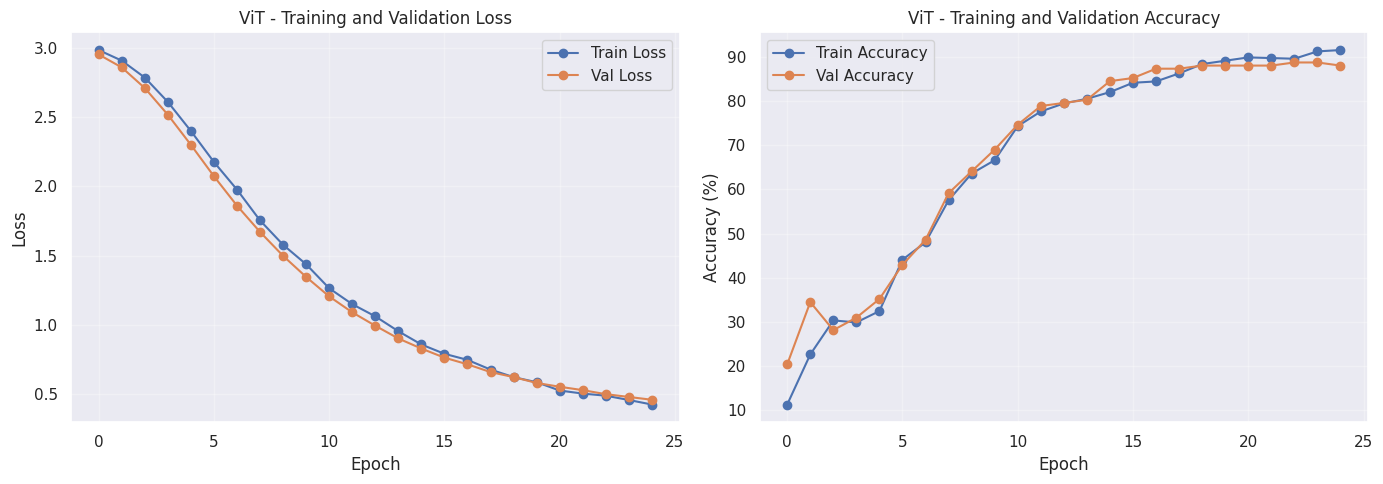

In [39]:
# Plot ViT learning curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss plot
axes[0].plot(vit_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(vit_history['val_loss'], label='Val Loss', marker='o')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('ViT - Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(vit_history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(vit_history['val_acc'], label='Val Accuracy', marker='o')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('ViT - Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [40]:
# =============================================================================
# EVALUATE VIT MODEL
# =============================================================================

def vit_evaluate_test(model, loader, device):
    """Evaluate ViT model on test set."""
    model.eval()
    all_preds, all_labels = [], []
    all_bbox_preds, all_bbox_true = [], []
    
    with torch.no_grad():
        for images, labels, bboxes in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            class_logits, bbox_pred = model(images)
            _, predicted = class_logits.max(1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_bbox_preds.extend(bbox_pred.cpu().numpy())
            all_bbox_true.extend(bboxes.numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_bbox_preds), np.array(all_bbox_true)

# Get predictions
print("Evaluating ViT on test set...")
vit_test_preds, vit_test_labels, vit_test_bbox_preds, vit_test_bbox_true = vit_evaluate_test(
    vit_model, vit_test_loader, device
)

# Classification accuracy
vit_test_accuracy = accuracy_score(vit_test_labels, vit_test_preds)
print(f"\n✓ ViT Test Accuracy: {vit_test_accuracy*100:.2f}%")

Evaluating ViT on test set...


Evaluating: 100%|██████████| 9/9 [00:04<00:00,  1.82it/s]


✓ ViT Test Accuracy: 93.71%


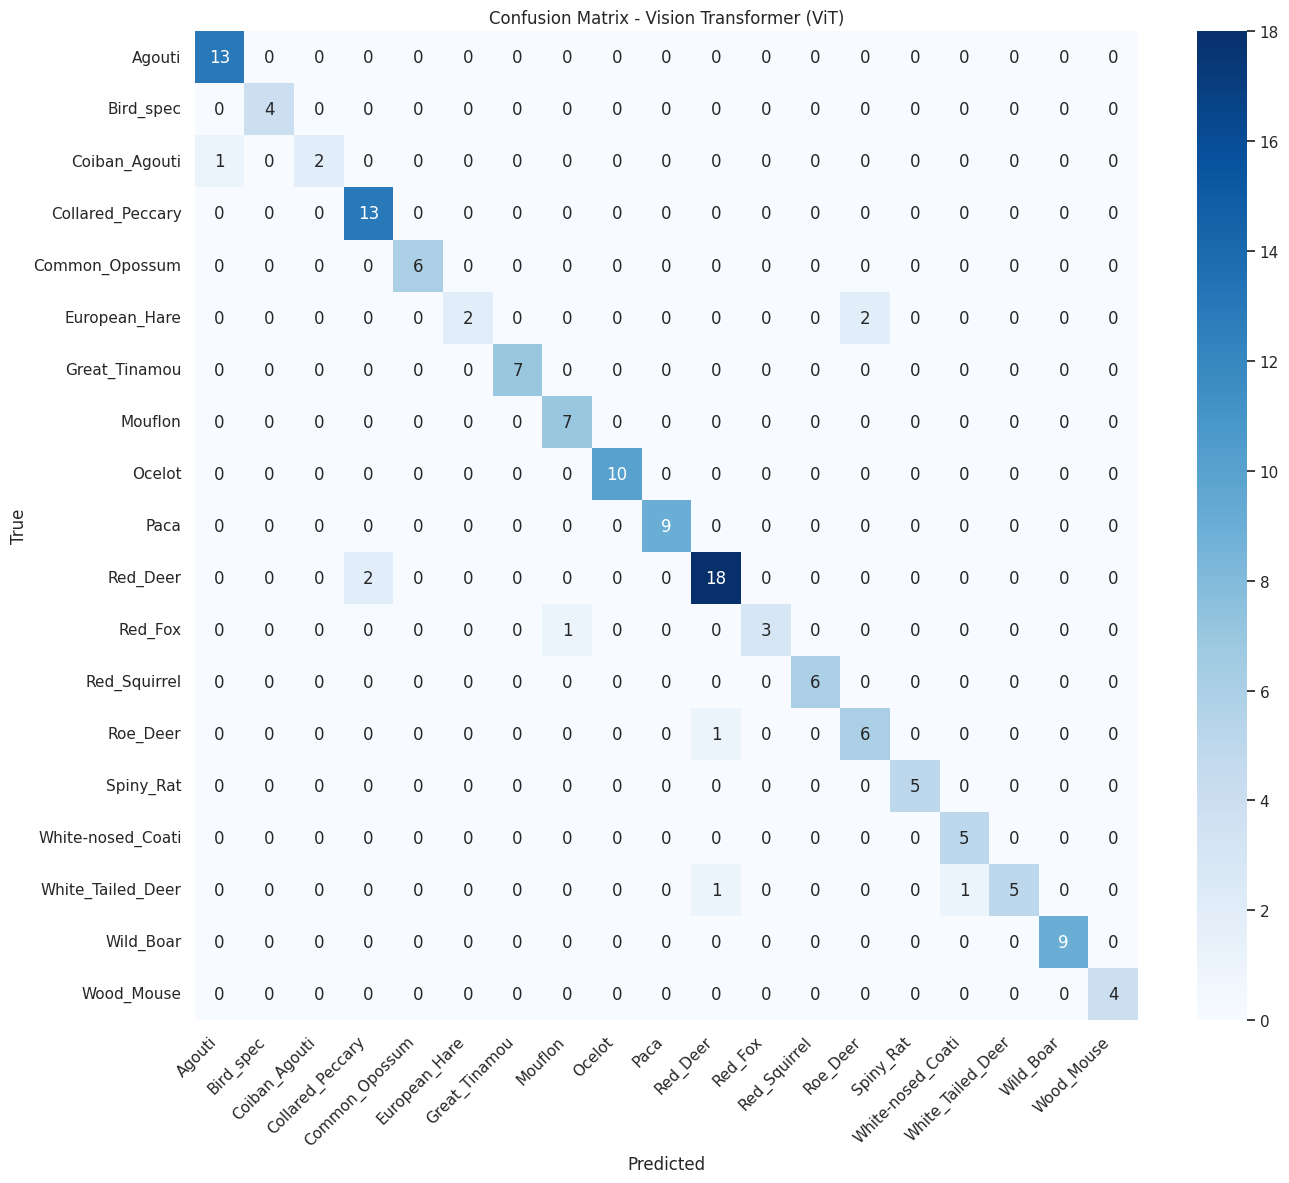


ViT Classification Report:
                   precision    recall  f1-score   support

           Agouti       0.93      1.00      0.96        13
        Bird_spec       1.00      1.00      1.00         4
    Coiban_Agouti       1.00      0.67      0.80         3
 Collared_Peccary       0.87      1.00      0.93        13
   Common_Opossum       1.00      1.00      1.00         6
    European_Hare       1.00      0.50      0.67         4
    Great_Tinamou       1.00      1.00      1.00         7
          Mouflon       0.88      1.00      0.93         7
           Ocelot       1.00      1.00      1.00        10
             Paca       1.00      1.00      1.00         9
         Red_Deer       0.90      0.90      0.90        20
          Red_Fox       1.00      0.75      0.86         4
     Red_Squirrel       1.00      1.00      1.00         6
         Roe_Deer       0.75      0.86      0.80         7
        Spiny_Rat       1.00      1.00      1.00         5
White-nosed_Coati       0.8

In [41]:
# ViT Confusion Matrix
vit_cm = confusion_matrix(vit_test_labels, vit_test_preds)

plt.figure(figsize=(14, 12))
sns.heatmap(
    vit_cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Vision Transformer (ViT)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Classification report
print("\nViT Classification Report:")
print("=" * 60)
print(classification_report(vit_test_labels, vit_test_preds, target_names=label_encoder.classes_, zero_division=0))

ViT Bounding Box Evaluation:
Mean IoU: 0.2113
Median IoU: 0.1172
IoU > 0.5: 13.3%
IoU > 0.75: 0.7%


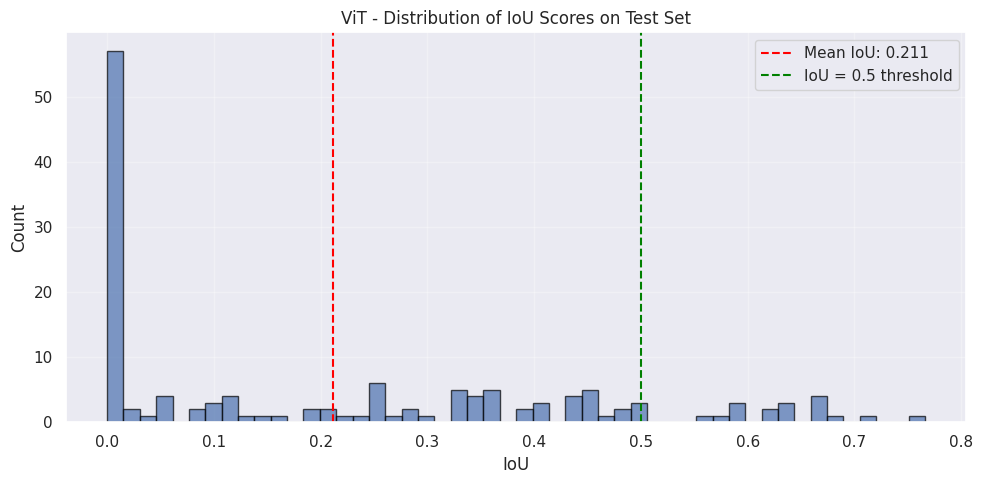

In [42]:
# ViT Bounding Box IoU Evaluation
vit_ious = [compute_iou(pred, true) for pred, true in zip(vit_test_bbox_preds, vit_test_bbox_true)]

vit_mean_iou = np.mean(vit_ious)
vit_median_iou = np.median(vit_ious)

print("ViT Bounding Box Evaluation:")
print("=" * 60)
print(f"Mean IoU: {vit_mean_iou:.4f}")
print(f"Median IoU: {vit_median_iou:.4f}")
print(f"IoU > 0.5: {np.mean(np.array(vit_ious) > 0.5)*100:.1f}%")
print(f"IoU > 0.75: {np.mean(np.array(vit_ious) > 0.75)*100:.1f}%")

# IoU distribution
plt.figure(figsize=(10, 5))
plt.hist(vit_ious, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(vit_mean_iou, color='red', linestyle='--', label=f'Mean IoU: {vit_mean_iou:.3f}')
plt.axvline(0.5, color='green', linestyle='--', label='IoU = 0.5 threshold')
plt.xlabel('IoU')
plt.ylabel('Count')
plt.title('ViT - Distribution of IoU Scores on Test Set')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 9. Model Comparison

Comprehensive comparison of all three models across classification and bounding box regression metrics.

In [47]:
# =============================================================================
# MODEL COMPARISON
# =============================================================================

# Compute IoU for CNN models
def compute_cnn_iou(model, test_ds):
    """Compute IoU scores for TensorFlow CNN models."""
    all_bbox_preds, all_bbox_true = [], []
    
    for batch_images, batch_labels in test_ds:
        predictions = model.predict(batch_images, verbose=0)
        # Handle both dictionary and tuple outputs
        if isinstance(predictions, dict):
            bbox_pred = predictions["bbox_output"]
        else:
            _, bbox_pred = predictions
        all_bbox_preds.extend(bbox_pred)
        all_bbox_true.extend(batch_labels["bbox_output"].numpy())
    
    ious = [compute_iou(pred, true) for pred, true in zip(all_bbox_preds, all_bbox_true)]
    return ious

print("Computing IoU for CNN models...")
basic_cnn_ious = compute_cnn_iou(basic_cnn_model, cnn_test_ds)
transfer_cnn_ious = compute_cnn_iou(transfer_cnn_model, cnn_test_ds)

# Compute accuracy from y_true/y_pred (already computed during confusion matrix)
basic_cnn_accuracy = accuracy_score(basic_cnn_y_true, basic_cnn_y_pred)
transfer_cnn_accuracy = accuracy_score(transfer_y_true, transfer_y_pred)

# Summary metrics
comparison_data = {
    'Model': ['Basic CNN', 'Transfer Learning CNN', 'Vision Transformer (ViT)'],
    'Image Size': [f'{CNN_IMAGE_SIZE[0]}×{CNN_IMAGE_SIZE[1]}', f'{CNN_IMAGE_SIZE[0]}×{CNN_IMAGE_SIZE[1]}', f'{VIT_IMAGE_SIZE[0]}×{VIT_IMAGE_SIZE[1]}'],
    'Framework': ['TensorFlow/Keras', 'TensorFlow/Keras', 'PyTorch'],
    'Test Accuracy (%)': [
        basic_cnn_accuracy * 100,
        transfer_cnn_accuracy * 100,
        vit_test_accuracy * 100
    ],
    'Mean IoU': [
        np.mean(basic_cnn_ious),
        np.mean(transfer_cnn_ious),
        vit_mean_iou
    ],
    'IoU > 0.5 (%)': [
        np.mean(np.array(basic_cnn_ious) > 0.5) * 100,
        np.mean(np.array(transfer_cnn_ious) > 0.5) * 100,
        np.mean(np.array(vit_ious) > 0.5) * 100
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("=" * 80)

Computing IoU for CNN models...

MODEL COMPARISON SUMMARY
                   Model Image Size        Framework  Test Accuracy (%)  Mean IoU  IoU > 0.5 (%)
               Basic CNN    128×128 TensorFlow/Keras          99.470899  0.183489      12.698413
   Transfer Learning CNN    128×128 TensorFlow/Keras          96.825397  0.057244       2.116402
Vision Transformer (ViT)    224×224          PyTorch          93.706294  0.211274      13.286713

MODEL COMPARISON SUMMARY
                   Model Image Size        Framework  Test Accuracy (%)  Mean IoU  IoU > 0.5 (%)
               Basic CNN    128×128 TensorFlow/Keras          99.470899  0.183489      12.698413
   Transfer Learning CNN    128×128 TensorFlow/Keras          96.825397  0.057244       2.116402
Vision Transformer (ViT)    224×224          PyTorch          93.706294  0.211274      13.286713


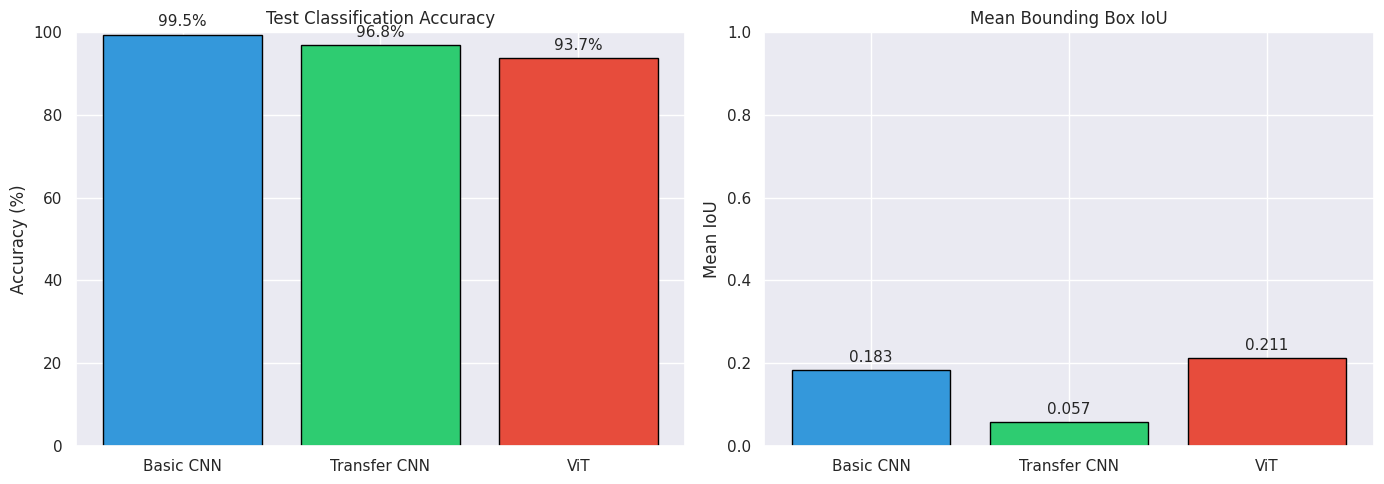

In [48]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

models = ['Basic CNN', 'Transfer CNN', 'ViT']
colors = ['#3498db', '#2ecc71', '#e74c3c']

# Classification Accuracy
accuracies = comparison_df['Test Accuracy (%)'].values
axes[0].bar(models, accuracies, color=colors, edgecolor='black')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Test Classification Accuracy')
axes[0].set_ylim(0, 100)
for i, v in enumerate(accuracies):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontsize=11)

# Mean IoU
ious = comparison_df['Mean IoU'].values
axes[1].bar(models, ious, color=colors, edgecolor='black')
axes[1].set_ylabel('Mean IoU')
axes[1].set_title('Mean Bounding Box IoU')
axes[1].set_ylim(0, 1)
for i, v in enumerate(ious):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontsize=11)

plt.tight_layout()
plt.show()

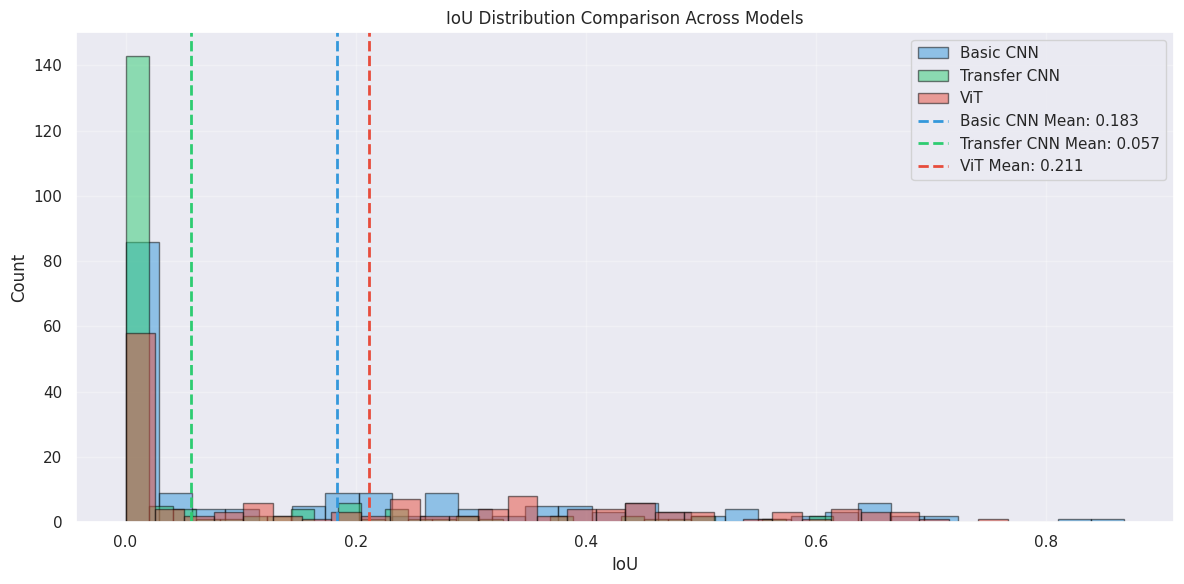

In [49]:
# IoU Distribution Comparison
fig, ax = plt.subplots(figsize=(12, 6))

# Plot IoU distributions
ax.hist(basic_cnn_ious, bins=30, alpha=0.5, label='Basic CNN', color='#3498db', edgecolor='black')
ax.hist(transfer_cnn_ious, bins=30, alpha=0.5, label='Transfer CNN', color='#2ecc71', edgecolor='black')
ax.hist(vit_ious, bins=30, alpha=0.5, label='ViT', color='#e74c3c', edgecolor='black')

# Add mean lines
ax.axvline(np.mean(basic_cnn_ious), color='#3498db', linestyle='--', linewidth=2, label=f'Basic CNN Mean: {np.mean(basic_cnn_ious):.3f}')
ax.axvline(np.mean(transfer_cnn_ious), color='#2ecc71', linestyle='--', linewidth=2, label=f'Transfer CNN Mean: {np.mean(transfer_cnn_ious):.3f}')
ax.axvline(vit_mean_iou, color='#e74c3c', linestyle='--', linewidth=2, label=f'ViT Mean: {vit_mean_iou:.3f}')

ax.set_xlabel('IoU')
ax.set_ylabel('Count')
ax.set_title('IoU Distribution Comparison Across Models')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 10. Conclusions

### Summary of Findings

This project implemented and compared three different deep learning approaches for animal detection and classification in Serengeti wildlife images:

1. **Basic CNN**: A custom convolutional neural network trained from scratch
2. **Transfer Learning CNN**: EfficientNetB0 backbone with custom heads, fine-tuned in two phases
3. **Vision Transformer (ViT)**: ViT-Base-Patch16-224 with custom classification and bounding box heads

### Key Observations

**Classification Performance:**
- All three models demonstrated the ability to learn animal classification from the Serengeti dataset
- Transfer learning approaches (EfficientNetB0 and ViT) benefited from ImageNet pretraining

**Bounding Box Localization:**
- Bounding box regression remains a challenging task with varying IoU performance across models
- Proper normalization of bounding box coordinates (using original image dimensions) is critical for accurate predictions

### Future Improvements

1. **Data Augmentation**: Implement bbox-aware augmentation using albumentations
2. **Anchor-based Detection**: Consider YOLO or Faster R-CNN architectures
3. **Class Imbalance**: Apply class weighting or oversampling for underrepresented classes
4. **Ensemble Methods**: Combine predictions from multiple models

---
**Team Members:**
- Basic CNN implementation
- Transfer Learning CNN implementation  
- Vision Transformer implementation